In [1]:
# main function
import numpy as np
import torch
import matplotlib.pyplot as plt
import botorch

from xopt.bayesian.algorithms import bayesian_exploration

from botorch.models import SingleTaskGP, ModelListGP
from botorch.fit import fit_gpytorch_model
from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood

import os
SMOKE_TEST = os.environ.get('SMOKE_TEST')

# test function
from xopt.tests.evaluators import TNK


In [2]:
# To see log messages
from xopt import output_notebook
output_notebook()

In [3]:
"""
    Example where we must use a custom botorch model to make predictions. 
    We modify the test_TNK function with a wrapper to return Nan values for the y1 objective if one of the constraints are not satisfied.
    To accomidate this we define a ModelListGP model as a custom model to remove Nan values from the training data.

"""

# define a new test function that returns nans for y1 if c1 is not valid
def nan_test_TNK(x):
    outputs = TNK.evaluate_TNK(x)
    if outputs['c1'] < 0:
        outputs['y1'] = np.nan
        
    return outputs


# Get VOCS
VOCS = TNK.VOCS
VOCS['objectives'] = {'y1' : 'MINIMIZE'}

# add reference point
ref = torch.tensor((1.4, 1.4))

print(VOCS)
# Get evaluate function
EVALUATE = nan_test_TNK
n_steps = 30
generator_options = {}

if SMOKE_TEST:
    generator_options = {'batch_size': 1,
                           'num_restarts': 2,
                           'raw_samples': 2}
    n_steps = 3


# Run
init_x = torch.tensor([[0.9, 0.9], [0.6, 0.6]])
results = bayesian_exploration(VOCS, EVALUATE,
                               n_initial_samples=5,
                               initial_x=None,
                               n_steps=n_steps,
                               generator_options=generator_options)

{'name': 'TNK_test', 'description': 'Constrainted test function TNK. See Table V in https://www.iitk.ac.in/kangal/Deb_NSGA-II.pdf', 'simulation': 'test_TNK', 'variables': {'x1': [0, 3.14159], 'x2': [0, 3.14159]}, 'objectives': {'y1': 'MINIMIZE'}, 'constraints': {'c1': ['GREATER_THAN', 0], 'c2': ['LESS_THAN', 0.5]}, 'constants': {'a': 'dummy_constant'}}
started running optimization with generator: <xopt.bayesian.generators.exploration.BayesianExplorationGenerator object at 0x10ad3e6a0>
submitting initial candidates
starting optimization loop
submitting candidates
[tensor([ 0.8438, -1.0855,  0.8276,  0.4986, -1.0845], dtype=torch.float64), tensor([-6.6157, -7.6360, -8.7276, -1.0478, -2.7242,  1.6097],
       dtype=torch.float64), tensor([6.5818, 6.3643, 8.3296, 2.0190, 3.1062, 0.9581], dtype=torch.float64)]
submitting candidates
[tensor([ 0.6525, -1.2661,  0.6365,  0.3093, -1.2650,  0.9328],
       dtype=torch.float64), tensor([-6.7657, -7.7804, -8.8659, -1.2285, -2.8957,  1.4143,  0.566

dict_keys(['variables', 'objectives', 'corrected_objectives', 'constraint_status', 'feasibility', 'model', 'constraints', 'corrected_constraints'])
tensor([[0.2523],
        [1.9801],
        [0.2668],
        [0.5614],
        [1.9791],
        [   nan],
        [0.0000],
        [0.9807],
        [   nan],
        [1.1415],
        [0.8600],
        [0.4496],
        [0.2012],
        [1.0513],
        [1.1086],
        [1.0289],
        [0.6484],
        [0.0779],
        [1.1936],
        [0.3116],
        [0.8525],
        [1.0898],
        [1.0352],
        [0.5137],
        [1.1639],
        [0.8385],
        [0.0603],
        [0.7174],
        [0.2862],
        [   nan],
        [0.9649],
        [   nan],
        [   nan],
        [1.1662],
        [   nan]], dtype=torch.float64)


Text(0, 0.5, '$x_2$')

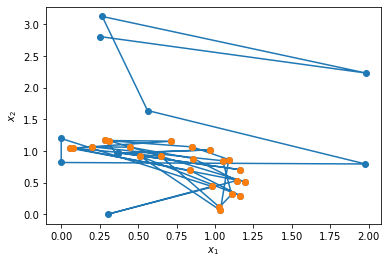

In [4]:
fig, ax = plt.subplots()
print(results.keys())
variables = results['variables']
print(results['objectives'])
valid = results['variables'][results['feasibility'].flatten()]
ax.plot(variables[:, 0], variables[:, 1], '-o')
ax.plot(valid[:, 0], valid[:, 1], 'o')
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
